# Tanh Exploration


In [1]:
import torch

import torch.nn as nn
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F


from qpth.qp import QPFunction
import qpth

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
print(torch.__version__)

1.8.1


Declare a simple network.

```
FC-ReLU-FC-Tanh-QP-Softmax
```

Where the QP OptNet layer learns the coefficients `A(z_i), b(z_i)` for a QP with inequality constraints:

```
z_{i+1} = argmin_d 0.5 d^T I d + {1}^n d
          s.t. A(z_i)d = b(z_i)
```


In [2]:
class OptNet(nn.Module):
    def __init__(self, nFeatures, nHidden, nCls, bn, nineq=10, neq=0, eps=1e-4):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden = nHidden
        self.bn = bn
        self.nCls = nCls
        self.nineq = nineq
        self.neq = neq
        self.eps = eps

        self.fc1 = nn.Linear(nFeatures, nHidden)
        self.fc2 = nn.Linear(nHidden, nineq * nCls + nineq)

    def forward(self, x):
        nBatch = x.size(0)
        eps = 1

        # Normal FC network.
        x = x.view(nBatch, -1)
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        
        Q = Variable(torch.eye(self.nCls))
        q = Variable(torch.ones(self.nCls))
        G = torch.zeros((self.nCls, self.nCls))
        h = torch.zeros(self.nCls)
        x_t = x[:, :self.nineq * self.nCls]
        
        A = x_t.reshape(nBatch, self.nineq, self.nCls)
        x_b = x[:, self.nineq * self.nCls:]
        b = x_b
        
        x = QPFunction(verbose=-1)(Q, q, G, h, A, b)

        return F.log_softmax(x)

In [3]:
class OptNetDef(nn.Module):
    def __init__(self, nFeatures, nHidden, nCls, bn, nineq=10, neq=0, eps=1e-4):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden = nHidden
        self.bn = bn
        self.nCls = nCls
        self.nineq = nineq
        self.neq = neq
        self.eps = eps

        self.fc1 = nn.Linear(nFeatures, nHidden)
        self.fc2 = nn.Linear(nHidden, nineq * nCls + nineq)

    def forward(self, x):
        nBatch = x.size(0)
        eps = 1

        # Normal FC network.
        x = x.view(nBatch, -1)
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        
        Q = Variable(torch.eye(self.nCls))
        q = Variable(torch.ones(self.nCls))
        G = torch.zeros((self.nCls, self.nCls))
        h = torch.zeros(self.nCls)
        x_t = x[:, :self.nineq * self.nCls]
        
        A = x_t.reshape(nBatch, self.nineq, self.nCls)
        
        # defence
        U, S, V = torch.svd(A)
        S_p = torch.zeros_like(S)
        for i in range(nBatch):
            S_p[i] = torch.clamp(S[i], torch.max(S[i]).item()/(2), torch.max(S[i]).item())
        
        A_p = U @ torch.diag_embed(S_p) @ torch.transpose(V, 1, 2)
        x_b = x[:, self.nineq * self.nCls:]
        b = x_b
        
        x = QPFunction(verbose=-1)(Q, q, G, h, A_p, b)

        return F.log_softmax(x)

In [4]:
# Loss via condition number of the matrix A
def ConditionNumberLoss(A, single_point=False):
    A_inv = torch.pinverse(A)
    if single_point:
        A_norm = torch.norm(A, 'fro')
        A_inv_norm = torch.norm(A_inv, 'fro')
    else:
        A_norm = torch.norm(A, 'fro', dim=(1,2))
        A_inv_norm = torch.norm(A_inv, 'fro', dim=(1,2))
    
    cond_num = A_inv_norm * A_norm
    return -cond_num

# Training the Model (to be attacked) and attacking the condition number of the matrix (all data points)

In [13]:
import math
import torch.optim as optim

torch.manual_seed(3)
nBatch, nFeatures, nHidden, nCls = 16, 20, 20, 2
# Create random data
x = Variable(torch.randn(nBatch, nFeatures), requires_grad=False)
y = Variable((torch.rand(nBatch) < 0.5).long(), requires_grad=False)

model = OptNet(nFeatures, nHidden, nCls, bn=False)
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(100):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 10 == 0:
        print(t, loss.item())
    # losses.append(loss.data)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the zloss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

# from https://adversarial-ml-tutorial.org/introduction/ (modified to respect the dataset)
epsilon = 2./255 * (torch.norm(x, p=float('inf')))
delta = torch.zeros_like(x, requires_grad=True)
opt = optim.SGD([delta], lr=1, momentum=0.9)
current_x = x
cond = []


for t in range(10000):
    x = current_x
    nBatch = x.size(0)

    # Normal FC network.
    x = x.view(nBatch, -1)
    x = F.relu(model.fc1(x + delta))
    x = F.tanh(model.fc2(x))
    x_t = x[:, :model.nineq * model.nCls]
    A = x_t.reshape(nBatch, model.nineq, model.nCls)

    # calculate loss (based on one data point so we only backpropagate a single data point)
    loss = ConditionNumberLoss(A)
    if t%10 == 0:
        print(t, loss)
    opt.zero_grad()
    loss[0].backward()
    opt.step()
    
    x = current_x
    x = x.view(nBatch, -1)
    x = F.relu(model.fc1(x + delta))
    x = F.tanh(model.fc2(x))
    x_t = x[:, :model.nineq * model.nCls]
    A = x_t.reshape(nBatch, model.nineq, model.nCls)
    cond.append(torch.linalg.cond(A[0]).item())
    
    # See if it still works
    y_pred = model(current_x + delta)
    loss = loss_fn(y_pred, y)
    if math.isnan(loss):
        print("Found adversarial attack")
        break
    if t%100 == 0:
        print('Actual Output with Modified x: Iteration {}, loss = {:.2f}'.format(t, loss.data))


\anaconda3\envs\layers\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
\anaconda3\envs\layers\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0 3.128049373626709
10 21.67911148071289
20 7.68596887588501
30 26.975568771362305
40 7.2960734367370605
50 2.2481019496917725
60 8.32046890258789
70 11.722784996032715
80 3.2623729705810547
90 26.806663513183594
0 tensor([-2.5035, -2.7667, -2.1914, -2.1393, -2.8190, -2.0992, -3.3380, -2.1841,
        -2.9686, -2.0405, -2.5187, -2.2801, -2.0006, -2.8889, -2.2067, -2.2461],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 0, loss = 22.09
10 tensor([-2.1042, -2.7667, -2.1914, -2.1393, -2.8190, -2.0992, -3.3380, -2.1841,
        -2.9686, -2.0405, -2.5187, -2.2801, -2.0006, -2.8889, -2.2067, -2.2461],
       grad_fn=<NegBackward>)
20 tensor([-2.3171, -2.7667, -2.1914, -2.1393, -2.8190, -2.0992, -3.3380, -2.1841,
        -2.9686, -2.0405, -2.5187, -2.2801, -2.0006, -2.8889, -2.2067, -2.2461],
       grad_fn=<NegBackward>)
30 tensor([-2.9429, -2.7667, -2.1914, -2.1393, -2.8190, -2.0992, -3.3380, -2.1841,
        -2.9686, -2.0405, -2.5187, -2.2801, -2.0006, -2.8889, -2.2

In [14]:
print(current_x)
print(current_x + delta)
print(model(current_x + delta))

tensor([[-0.0766,  0.3599, -0.7820,  0.0715,  0.6648, -0.2868,  1.6206, -1.5967,
         -0.0517, -0.3060,  0.2485, -0.2226,  0.9132,  0.2043,  0.5740,  0.4163,
          0.2615,  0.9311, -0.5145, -1.6517],
        [ 1.0460,  0.5222, -0.1668,  0.0530,  0.5638,  2.2566,  1.8693, -1.1952,
          0.9979,  0.4592,  2.4364, -0.1468, -0.4760, -0.2929, -0.3481,  0.3487,
          0.0371, -0.0677,  0.4290, -0.8681],
        [-0.2712,  0.1416,  0.1295,  0.6814, -0.9583,  0.0639,  0.6589,  0.8195,
         -0.4554,  2.2124, -0.3770, -0.1437,  0.6480, -2.3256,  1.2683, -0.2483,
          0.9578, -1.2890, -1.6483,  0.8290],
        [-0.8373, -0.5296,  1.3544,  1.3778, -0.0752, -0.4233,  0.4217, -0.2576,
         -1.5835,  1.3960, -1.0319,  1.1391,  0.5125, -0.0198, -1.1216, -0.4891,
         -0.6336, -0.7893, -0.8977, -1.8876],
        [ 0.1870, -0.1813, -0.0914, -0.7349,  1.9859,  0.3625, -1.3898, -0.1593,
          0.3290,  0.3323,  0.3025, -0.9812,  1.1038, -0.0127, -0.6851, -0.3094,
      

\anaconda3\envs\layers\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
\anaconda3\envs\layers\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5, 0, 'Iteration')

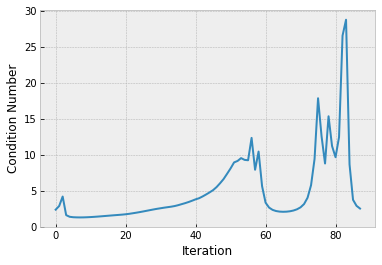

In [15]:
plt.plot(cond)
plt.ylabel('Condition Number')
plt.xlabel('Iteration')

# Training the Model (to be attacked) and applying the defence

In [16]:
import math
import torch.optim as optim

torch.manual_seed(3)
nBatch, nFeatures, nHidden, nCls = 16, 20, 20, 2
# Create random data
x = Variable(torch.randn(nBatch, nFeatures), requires_grad=False)
y = Variable((torch.rand(nBatch) < 0.5).long(), requires_grad=False)

model = OptNetDef(nFeatures, nHidden, nCls, bn=False)
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(100):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 10 == 0:
        print(t, loss.item())
    # losses.append(loss.data)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the zloss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

# from https://adversarial-ml-tutorial.org/introduction/ (modified to respect the dataset)
epsilon = 2./255 * (torch.norm(x, p=float('inf')))
delta = torch.zeros_like(x, requires_grad=True)
opt = optim.SGD([delta], lr=1, momentum=0.9)
current_x = x
cond = []

for t in range(5000):
    x = current_x
    nBatch = x.size(0)

    # Normal FC network.
    x = x.view(nBatch, -1)
    x = F.relu(model.fc1(x + delta))
    x = F.tanh(model.fc2(x))

    x_t = x[:, :model.nineq * model.nCls]
    A = x_t.reshape(nBatch, model.nineq, model.nCls)
    U, S, V = torch.svd(A)
    S_p = torch.zeros_like(S)
    for i in range(nBatch):
        S_p[i] = torch.clamp(S[i], torch.max(S[i]).item()/(2), torch.max(S[i]).item())

    A_p = U @ torch.diag_embed(S_p) @ torch.transpose(V, 1, 2)
    

    loss = ConditionNumberLoss(A_p)
    if t%10 == 0:
        print(t, loss)
        print(t, ConditionNumberLoss(A_p))
    opt.zero_grad()
    loss[0].backward()
    opt.step()
    
    x = current_x
    x = x.view(nBatch, -1)
    x = F.relu(model.fc1(x + delta))
    x = F.tanh(model.fc2(x))
    x_t = x[:, :model.nineq * model.nCls]
    A = x_t.reshape(nBatch, model.nineq, model.nCls)
    cond.append(torch.linalg.cond(A[0]).item())
    
    # See if it still works
    y_pred = model(current_x + delta)
    loss = loss_fn(y_pred, y)
    if math.isnan(loss):
        print("Found adversarial attack")
        print(ConditionNumberLoss(A))
        print(A_p)
        break
    if t%10 == 0:
        print('Actual Output with Modified x: Iteration {}, loss = {:.2f}'.format(t, loss.data))


\anaconda3\envs\layers\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
\anaconda3\envs\layers\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0 15.932493209838867
10 9.020636558532715
20 5.355899810791016
30 17.271055221557617
40 14.288124084472656
50 2.335761785507202
60 1.8374788761138916
70 6.211880683898926
80 5.331652641296387
90 25.419483184814453
0 tensor([-2.3561, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
0 tensor([-2.3561, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 0, loss = 4.00
10 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
10 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.17

180 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
180 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 180, loss = 3.11
190 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
190 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 190, loss = 3.07
200 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.

370 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
370 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 370, loss = 3.11
380 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
380 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 380, loss = 3.31
390 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.

560 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
560 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 560, loss = 3.08
570 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
570 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 570, loss = 3.08
580 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.

750 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
750 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 750, loss = 3.20
760 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
760 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 760, loss = 3.07
770 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.

940 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
940 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 940, loss = 3.06
950 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
950 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 950, loss = 4.06
960 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.

1130 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1130 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1130, loss = 3.08
1140 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1140 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1140, loss = 3.31
1150 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

1320 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1320 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1320, loss = 4.06
1330 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1330 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1330, loss = 3.07
1340 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

1510 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1510 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1510, loss = 3.06
1520 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1520 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1520, loss = 3.06
1530 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

1700 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1700 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1700, loss = 3.63
1710 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1710 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1710, loss = 3.31
1720 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

1890 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1890 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1890, loss = 3.06
1900 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
1900 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 1900, loss = 3.09
1910 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

2080 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2080 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2080, loss = 3.06
2090 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2090 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2090, loss = 3.11
2100 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

2270 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2270 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2270, loss = 3.08
2280 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2280 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2280, loss = 3.07
2290 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

2460 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2460 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2460, loss = 3.06
2470 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2470 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2470, loss = 3.25
2480 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

2650 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2650 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2650, loss = 3.31
2660 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2660 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2660, loss = 3.20
2670 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

2840 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2840 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2840, loss = 3.50
2850 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
2850 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 2850, loss = 3.11
2860 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

3030 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3030 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3030, loss = 3.08
3040 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3040 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3040, loss = 3.06
3050 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

3220 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3220 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3220, loss = 3.07
3230 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3230 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3230, loss = 3.11
3240 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

3410 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3410 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3410, loss = 3.06
3420 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3420 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3420, loss = 3.07
3430 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

3600 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3600 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3600, loss = 3.78
3610 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3610 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3610, loss = 3.07
3620 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

3790 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3790 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3790, loss = 3.06
3800 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3800 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3800, loss = 3.11
3810 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

3980 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3980 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3980, loss = 3.20
3990 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
3990 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 3990, loss = 3.13
4000 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

4170 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4170 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4170, loss = 3.91
4180 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4180 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4180, loss = 3.25
4190 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

4360 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4360 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4360, loss = 3.20
4370 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4370 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4370, loss = 3.06
4380 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

4550 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4550 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4550, loss = 3.24
4560 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4560 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4560, loss = 3.08
4570 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

4740 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4740 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4740, loss = 3.06
4750 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4750 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4750, loss = 3.20
4760 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

4930 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4930 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4930, loss = 3.11
4940 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
4940 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.5000, -2.0713, -2.5000, -2.2178, -2.0014, -2.5000, -2.1700, -2.1919],
       grad_fn=<NegBackward>)
Actual Output with Modified x: Iteration 4940, loss = 3.06
4950 tensor([-2.5000, -2.5000, -2.2791, -2.1984, -2.5000, -2.1655, -2.5000, -2.2417,
        -2.50

In [17]:
print(delta)
print(model(current_x + delta))

tensor([[-40.6657,  25.2301, -16.9955, -47.2575,  -1.2921, -17.8748,  35.7583,
           7.2736,  14.8741,  -7.5092,  12.5921,   6.4208,   6.6733,   3.5514,
         -28.2521, -29.3244,  -3.0413,  -2.9372, -13.6235, -18.9660],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         

\anaconda3\envs\layers\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
\anaconda3\envs\layers\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5, 0, 'Iteration')

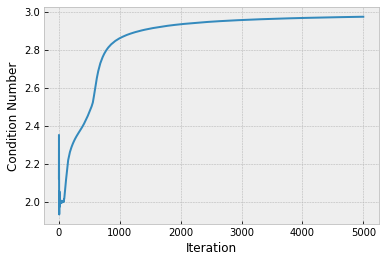

In [18]:
plt.plot(cond)
plt.ylabel('Condition Number')
plt.xlabel('Iteration')